In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import manifold
from sklearn import model_selection, linear_model

# Load features and labels

The script [`feature_extraction.py`](feature_extraction.py) is used to extract a 2048-dimensional feature vector for each image. It outputs files `features.npy` and `keys.npy` as follows:

* `features.npy` contains a NumPy array of shape (number of images, number of features) = (35126, 2048)
* `keys.npy` contains the corresponding image 'names' — the filenames without the .jpeg suffix. 

The file `trainLabels.csv` (part of the Kaggle data) maps these names to the level of diabetic retinopathy (0 — No DR, 1 — Mild, 2 — Moderate', 3 — Severe, 4 — Proliferative).

In [3]:
keys = np.load('keys.npy')
features = np.load('features.npy')
labels_df = pd.read_csv('trainLabels.csv', index_col='image')

# Check lengths are the same for all raw data
len(keys), len(features), len(labels_df)

(35126, 35126, 35126)

# Map image names to levels
Using an inner join.

In [4]:
features_df = pd.DataFrame(features, index=keys)
df = pd.merge(features_df, labels_df, how='inner', left_index=True, right_index=True)

In [5]:
df.head(4)

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,level
10_left,0.526682,0.043948,0.042256,0.029524,0.425382,0.424015,0.007560,0.458355,0.099644,0.203269,...,0.059844,0.088355,0.191702,0.202443,0.047101,0.340382,0.949681,0.095512,0.346594,0
10_right,0.316538,0.064303,0.111772,0.015365,0.415922,0.678155,0.001650,1.000529,0.061218,0.207925,...,0.177270,0.225751,0.339383,0.337852,0.251831,0.491701,0.638236,0.065918,0.579277,0
13_left,0.404190,0.400065,0.017244,0.058396,0.542456,0.463827,0.244821,0.653481,0.175902,0.143579,...,0.048567,0.257084,0.171873,0.019319,0.004694,0.102028,0.737695,0.232218,0.641074,0
13_right,0.520057,0.271358,0.013167,0.005301,0.710363,0.430825,0.019369,0.618148,0.147279,0.079770,...,0.001209,0.370906,0.084486,0.042817,0.014832,0.045585,0.765283,0.125689,0.619225,0


# Distribution of DR levels
There are many more images with no diabetic retinopathy (level = 0) than those with.

0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64

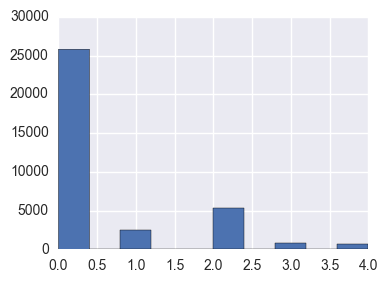

In [6]:
df.level.hist(figsize=(4,3));
df.level.value_counts()

# Balance classes

In [7]:
min_class = df.level.value_counts().min() # number of samples in smallest class
min_class

708

As we have 708 samples in the smallest class (class 4), we can simply use subsampling to even out the imbalance. Before that we recover features and labels as numpy arrays `X` and `y` suitable for `sklearn`.

In [8]:
feature_cols = df.columns[:-1]  # all columns except 'level'
X = df[feature_cols].values
y = df['level'].values

X.shape, y.shape

((35126, 2048), (35126,))

Simple random subsampling of the classes to get equal samples in each of the five classes.

In [9]:
np.random.seed(42)
min_class = pd.Series(y).value_counts().min() # number of samples in smallest class
#min_class = 100 # reduced dataset size for speed
# all_idx[y==label] selects all elements in X & y where y == label
# np.random.choice chooses a random subset of these of size min_class
all_idx = np.arange(len(X))
bal_idx = np.ravel([np.random.choice(all_idx[y==label], size=min_class, replace=False) 
                    for label in set(y)])

# Balanced X and y
X_bal = X[bal_idx]
y_bal = y[bal_idx]

# Check equal numbers of each level
pd.Series(y_bal).value_counts()

3    708
1    708
4    708
2    708
0    708
dtype: int64

# Visualize with t-SNE

I find t-SNE an excellent way to check if high-dimensional features separate into easily identifiable classes.

In [10]:
tsne = manifold.TSNE(n_components=2, init='random', perplexity=30, 
                     early_exaggeration=8, random_state=42)
X_tsne = tsne.fit_transform(X_bal)

### Create DataFrame for plotting

In [11]:
legend_map = {0:'No DR', 1:'Mild', 2:'Moderate', 3:'Severe', 4:'Proliferative'}
f = np.vectorize(lambda x: legend_map[x])
df_tsne = pd.DataFrame({'X0': X_tsne[:,0], 'X1': X_tsne[:,1], 'Level': f(y_bal)})

### Plot t-SNE

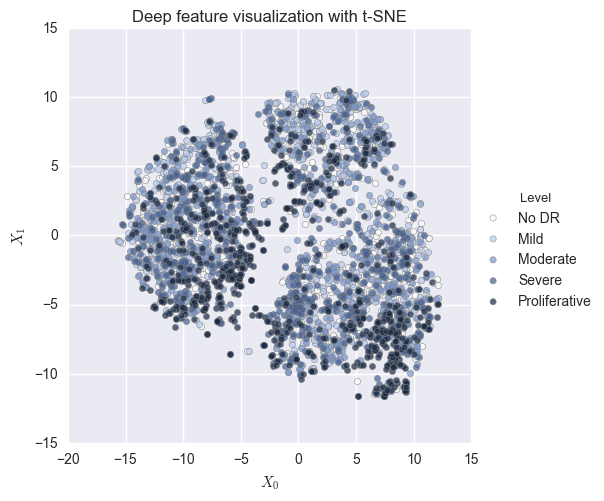

In [12]:
pal = sns.cubehelix_palette(n_colors=5, light=1.0, rot=0.0, start=2.8, hue=1.0)
sns.lmplot(data=df_tsne, x='X0', y='X1', hue='Level', 
           size=5, fit_reg=False, palette=pal, legend_out=True,
           scatter_kws={'s':20, 'edgecolors':'gray', 'linewidths':0.5, 'alpha':0.7});
plt.title('Deep feature visualization with t-SNE');
plt.xlabel('$X_0$');
plt.ylabel('$X_1$');

There are some clearly defined groups in the plot but unfortunately not great separation between the levels of diabetic retinopathy. (On further investigation the well-separated groups correspond to different croppings of the original images and whether the image is inverted.) 

The plot suggests that classifcation models will struggle to perform very well.

# Holdout set
on the balanced data

In [13]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_bal, y_bal, test_size=0.3,
                                                                    stratify=y_bal, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2478, 2048), (2478,), (1062, 2048), (1062,))

# Logistic regression
Fit a simple logisitic regression model on the balanced data.

In [14]:
clf = linear_model.LogisticRegression(C=0.1) 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

### Classification report

In [15]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.41      0.43      0.42       213
          1       0.34      0.34      0.34       212
          2       0.30      0.25      0.28       212
          3       0.47      0.45      0.46       213
          4       0.58      0.68      0.63       212

avg / total       0.42      0.43      0.42      1062



It looks like the model is best at identifying the most advanced level of DR (class 4 — proliferative DR).

### Confusion matrix
Calculate and print confusion matrix.

In [16]:
labels = [0,1,2,3,4]
cm = confusion_matrix(y_test, y_pred, labels=labels)
print(cm)

[[ 91  63  36  13  10]
 [ 68  72  47  16   9]
 [ 42  39  54  40  37]
 [ 14  29  27  95  48]
 [  7   7  14  40 144]]


Calculate confusion matrix normalised to row sums and display it as a heatmap with Seaborn.

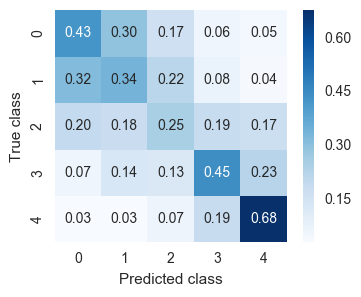

In [17]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(cm_norm, square=True, annot=True, fmt='0.2f',
            annot_kws={'fontsize':10}, cmap='Blues', 
            xticklabels=labels, yticklabels=labels);
plt.ylabel('True class');
plt.xlabel('Predicted class');

The model is surprisingly good at identifying the most advanced form of diabetic retinopathy (class 4). It manages to correctly identify 68 % of images that are labelled in this class and only mis-classifies 3 % as having no sign of diabetic retinopathy (class 0).

Unfortunately, the model is less good at differentiating between some level of diabetic retinopathy (classes 1–4) and no sign of the disease (class 0). In order for a model to be useful in a clinical environment it should, not only, be good at identifying the disease, but should minimise the number of false negatives (cases where the patient has diabetic retionpathy but the model fails to identify it — such patients might then not be sent for further investigtion and treatment.)